In [1]:
from fastai.vision import *
import torch
import pandas as pd
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
model_data = pd.read_csv('break_training_data.csv',sep='|')


model_data.head()


,Unnamed: 0,BREAK_NAME,RISK_VALUE,file_save,url
0,0,Urban,6,/mnt/data/break_names/urban/1521146.png,"https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=39.08584900000005,-108.51533799999999,39.08947500000005,-108.51067999999998&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/png&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"
1,1,Urban,6,/mnt/data/break_names/urban/1521360.png,"https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=39.07497200000006,-108.46409999999997,39.07859700000006,-108.45944199999997&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/png&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"
2,2,Urban,6,/mnt/data/break_names/urban/1521689.png,"https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=39.09310100000005,-108.47341599999999,39.096727000000044,-108.46875799999998&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/png&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"
3,3,Urban,6,/mnt/data/break_names/urban/1521922.png,"https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=39.07859700000006,-108.45944199999997,39.082223000000056,-108.45478399999996&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/png&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"
4,4,Urban,6,/mnt/data/break_names/urban/1522143.png,"https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=39.07859700000006,-108.51533799999999,39.082223000000056,-108.51067999999998&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/png&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"


In [2]:
torch.__version__, torch.cuda.is_available()

('1.9.0', True)

In [3]:
verify_image_flag = False
if verify_image_flag:
    
    model_data['verfied'] = model_data['file_save'].apply(verify_image)
    model_data['verfied'].mean()

In [4]:


# dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
#                   splitter = RandomSplitter(0.2,seed=42),
#                   get_items = lambda x: x[['file_save','BREAK_NAME']]),
#                 get_y = lambda x: x['BREAK_NAME'],
#                 get_x = lambda x: imread(x['file_save'])[...,0:2]
#                 batch_tfms=[*aug_transforms(size=224,min_scale=0.75),Normalize.from_stats(*imagenet_stats)])
dls = ImageDataLoaders.from_df(model_data[['file_save','BREAK_NAME']],path='/',valid_pct=.2,seed=42,
                               batch_tfms=[*aug_transforms(size=224,min_scale=0.75),Normalize.from_stats(*imagenet_stats)],bs=64)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


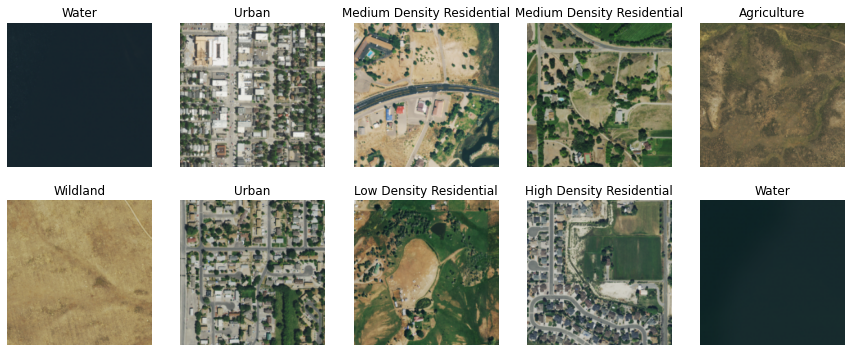

In [5]:
dls.valid.show_batch(max_n=10, nrows=2)

In [6]:
learn = cnn_learner(dls,resnet18, metrics=[error_rate,accuracy],loss_func=LabelSmoothingCrossEntropy(),path='.models').to_fp16()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


steepest point: 1.74e-03


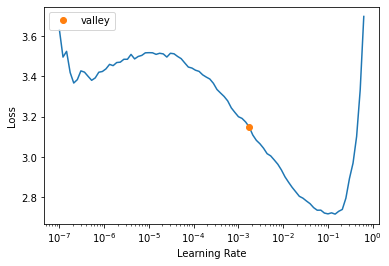

In [7]:


lr_steep = learn.lr_find()
lr_steep = lr_steep[0]
print(f"steepest point: {lr_steep:.2e}")



In [8]:
callbacks = [SaveModelCallback(fname='fire_break_model'),CSVLogger(append=True)]

In [9]:
learn.fine_tune(10,freeze_epochs=3,base_lr=lr_steep,cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.401026,1.584603,0.447619,0.552381,00:11
1,1.929649,1.457444,0.398413,0.601587,00:11
2,1.657806,1.335237,0.373810,0.626190,00:11


Better model found at epoch 0 with valid_loss value: 1.5846034288406372.
Better model found at epoch 1 with valid_loss value: 1.4574435949325562.
Better model found at epoch 2 with valid_loss value: 1.3352371454238892.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.416871,1.247102,0.336508,0.663492,00:13
1,1.331214,1.220996,0.332540,0.667460,00:12
2,1.260223,1.174729,0.302381,0.697619,00:12
3,1.184542,1.182053,0.317460,0.682540,00:12
4,1.096331,1.118629,0.280952,0.719048,00:12
5,1.048851,1.167885,0.303175,0.696825,00:12
6,0.979500,1.102918,0.272222,0.727778,00:12
7,0.944765,1.115948,0.293651,0.706349,00:12
8,0.911683,1.118040,0.296032,0.703968,00:12
9,0.889991,1.125471,0.296032,0.703968,00:12


Better model found at epoch 0 with valid_loss value: 1.247101902961731.
Better model found at epoch 1 with valid_loss value: 1.2209956645965576.
Better model found at epoch 2 with valid_loss value: 1.1747288703918457.
Better model found at epoch 4 with valid_loss value: 1.1186288595199585.
Better model found at epoch 6 with valid_loss value: 1.1029176712036133.


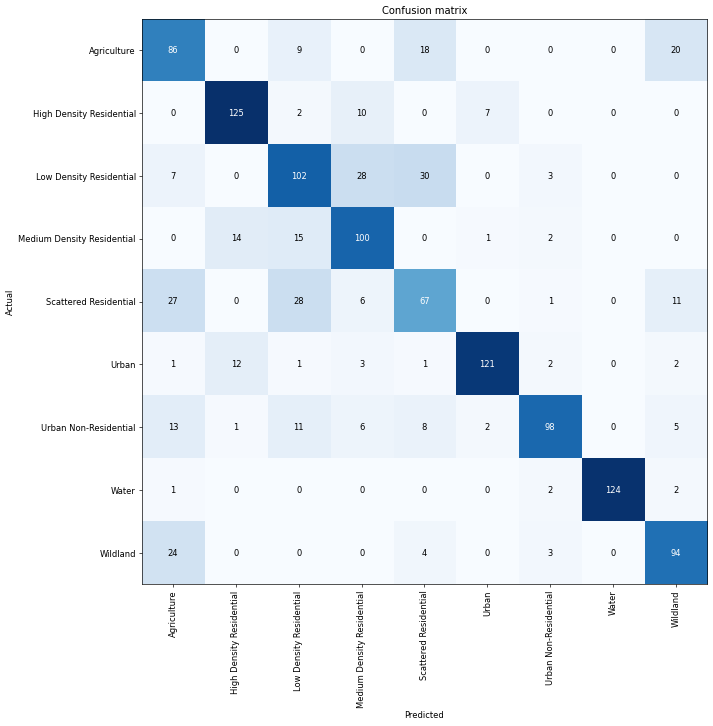

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:


interp.print_classification_report()



                            precision    recall  f1-score   support

               Agriculture       0.54      0.65      0.59       133
  High Density Residential       0.82      0.87      0.84       144
   Low Density Residential       0.61      0.60      0.60       170
Medium Density Residential       0.65      0.76      0.70       132
     Scattered Residential       0.52      0.48      0.50       140
                     Urban       0.92      0.85      0.88       143
     Urban Non-Residential       0.88      0.68      0.77       144
                     Water       1.00      0.96      0.98       129
                  Wildland       0.70      0.75      0.73       125

                  accuracy                           0.73      1260
                 macro avg       0.74      0.73      0.73      1260
              weighted avg       0.74      0.73      0.73      1260



In [12]:
interp.most_confused(min_val=5)

[('Low Density Residential', 'Scattered Residential', 30),
 ('Low Density Residential', 'Medium Density Residential', 28),
 ('Scattered Residential', 'Low Density Residential', 28),
 ('Scattered Residential', 'Agriculture', 27),
 ('Wildland', 'Agriculture', 24),
 ('Agriculture', 'Wildland', 20),
 ('Agriculture', 'Scattered Residential', 18),
 ('Medium Density Residential', 'Low Density Residential', 15),
 ('Medium Density Residential', 'High Density Residential', 14),
 ('Urban Non-Residential', 'Agriculture', 13),
 ('Urban', 'High Density Residential', 12),
 ('Scattered Residential', 'Wildland', 11),
 ('Urban Non-Residential', 'Low Density Residential', 11),
 ('High Density Residential', 'Medium Density Residential', 10),
 ('Agriculture', 'Low Density Residential', 9),
 ('Urban Non-Residential', 'Scattered Residential', 8),
 ('High Density Residential', 'Urban', 7),
 ('Low Density Residential', 'Agriculture', 7),
 ('Scattered Residential', 'Medium Density Residential', 6),
 ('Urban Non